# Assignment 2


#### 1. 复习上课内容以及复现课程代码

在本部分，你需要在复习上课内容和课程代码后，复现课程代码。 

#### 2. 回答以下理论题目

###       < 评阅点 >： 答案是否正确完整

###### 2.1 What conditions are required to make the BFS return the optimal solution ?

Answer：两个节点之间的费用或者值是大于等于0的，在算法中，每一次新的节点加入历史列表后，进行排序

##### 2.2 Is there a way to make DFS find the optimal solution ? (You may need to read some material about iterative DFS)

Answer: 使用迭代深度搜索，先给定一个深度，再此深度范围内进行搜索，如果没有搜索到目标，增加深度向下搜索，类似于广度和深度进行结合搜索。

##### 2.3 In what conditions BFS is a better choice than DFS and vice versa ?

Answer：

1. 考虑是否需要最优解，如果需要最优解，使用BFS，否则使用DFS

2. 若不需要最优解的情况，并且不考虑空间的情况是BFS和DFS都可使用，如果考虑空间的情况，只能使用DFS

##### 2.4 When can we use machine learning ?

Answer: 1. 回归问题 2. 分类问题

##### 2.5 What is the gradient of a function ?

Answer: 梯度是函数上升和下降最快路径


##### 2.6 How can we find the maximum value of a function using the information of gradient ?

In [ ]:
Answer: 使用梯度上升，每次x= x‘ + a * 梯度


#### 3. 实践部分  寻找地铁路线

### < 评阅点 >  1: 爬虫爬取数据是否完整;  2:搜索算法是否正确

In this part, although we recommend you to use Beijing subway, you still can use the subway map of any cities that you are interested in. 

![title](img/ditu.png)

Please using the search policy to implement an agent. This agent receives two input, one is @param start station and the other is @param destination. Your agent should give the optimal route based on Beijing Subway system.

Deadline: 2019-October-27

#### Procedures

github:

https://github.com/haojiefu007/MyPython/blob/master/Nlp/assignment_2/Assignment_02.ipynb

#### 1. Get data from web.  

Some tips: 

a. You might need this package: requests[https://2.python-requests.org/en/master/] to get webpages

b.You might need to use Regular Expression and Beautiful Soap package to parse the webpages

In [2]:
#请求方法
import requests
from bs4 import BeautifulSoup
import bs4
import json

def getHTMLText(url):
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        return r.text
    except:
        return ""

def getJsonDict(str):
    return json.loads(json_ret)


In [3]:
#考虑使用BeautifulSoup，但是网页未非静态网页，其中地铁信息获取不到
#故放弃
url = 'http://map.amap.com/subway/index.html?&1100'
html = getHTMLText(url)
soup = BeautifulSoup(html, "html.parser")

body = soup.find('body')
print(body.find_all('g'))

[]


In [4]:
#考虑直接读取json，分析json中的地铁信息
json_ret = getHTMLText('http://map.amap.com/service/subway?_1579845320253&srhdata=1100_drw_beijing.json')
data_dict = getJsonDict(json_ret)

##### 2. Preprocessing data

Some tips:

a. Find a suitable way to save the data you get from the web. (Note: The way you use to save the data should be able to be used to create the graph that your agent is going to explore)

In [5]:
import re

line_info = {}#存储线路信息
station_info = {}#存储站点信息
station_connection_info = {}#存储站点连接信息
station_transfer_info = {}#存储站点换乘信息

#初始化线路信息
def init_line_info(dict):
    for d in dict['l']:#循环线路信息
        linelist = []#初始化线路列表
        for l in d['st']:#循环站点信息
            linelist.append(l['n'])#添加站点名字
        line_info[d['ln']] = linelist#添加线路
    return line_info

#初始化站点信息
def init_station_info(dict):
    for d in dict['l']:#循环线路信息
        for l in d['st']:#循环站点信息
            station_name = l['n']
            x_y = re.findall("(\d+.\d+),(\d+.\d+)",l['sl'])[0]#经纬度坐标
            x_y = tuple(map(float,x_y))
            station_info[station_name] = x_y
    return station_info

#初始化站点连接信息
def init_station_connection_info():

    for linename,lines in line_info.items():
        for i in range(len(lines)):
            connection = []
            if i == 0:
                connection = [lines[i+1]] #连接后站
            elif i == len(lines) - 1:
                connection = [lines[i-1]] #连接前站
            else:
                connection = [lines[i-1],lines[i+1]] #连接前后站

            #判断有没有初始化过
            if lines[i] in station_connection_info:
                connection = connection + station_connection_info[lines[i]]

            station_connection_info[lines[i]] = connection

def init_station_transfer_info():
    for linename,lines in line_info.items():
        for i in range(len(lines) - 1):
            connection = lines[i] + ',' + lines[i+1] #连接后站
            station_transfer_info[connection] = linename
            connection = lines[i+1] + ',' + lines[i] #返程信息
            station_transfer_info[connection] = linename

In [6]:
#1
init_line_info(data_dict)
#print(line_info)

#2
init_station_info(data_dict)
#print(station_info)

#3
init_station_connection_info()

#4
init_station_transfer_info()

In [7]:
print(station_connection_info['奥体中心'])

['北土城', '奥林匹克公园']


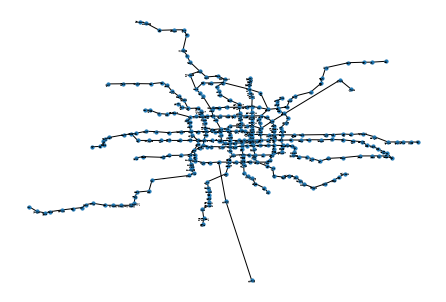

In [8]:
#绘图
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

station_graph = nx.Graph(station_connection_info)

station_graph.add_nodes_from(list(station_connection_info.keys()))
nx.draw(station_graph, station_info, with_labels=True, node_size=10,font_size = 2)

#### 3. Build the search agent

Build the search agent based ont he graph you built.

for example, if you use Beijing subway graoh, and you run:

In [9]:
def search_1bfs(start,destination,graph = station_connection_info,):
    pathes = [[start]]  # list 用来存储待搜索路径
    visited = set() # set用来存储已搜索的节点

    while pathes:
        path = pathes.pop(0)  #提取第一条路径
        froniter = path[-1]   #提取即将要探索的节点
        #print(path)
        if froniter in visited: continue  #检查如果该点已经探索过 则不用再探索
            
        successsors = graph[froniter]

        for city in successsors:      #遍历子节点
            if city in path: continue  # check loop #检查会不会形成环
            
            new_path = path+[city]
            #print(new_path)
            pathes.append(new_path)  #bfs     #将新路径加到list里面
            #pathes = [new_path] + pathes #dfs
            
            if city == destination:  #检查目的地是不是已经搜索到了
                return new_path
        visited.add(froniter)

In [10]:
print(search_1bfs("奥体中心","天安门西"))

['奥体中心', '北土城', '健德门', '牡丹园', '西土城', '知春路', '大钟寺', '西直门', '车公庄', '阜成门', '复兴门', '西单', '天安门西']


\>>> search("奥体中心“，”天安门“）

You should get the result as follows: 奥体中心 -> A ->B ->C ... -> 天安门

### (Optional) Improve your agent to make it able to find a path based on different strategies

###  <评阅点> : 是否正确得到不同目标下的路径。

Some ideas you might want to try:

a. Find the shortest path between two stations.

In [11]:
import math

def geo_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d
    
def get_station_distance(satation1,satation2):
    return geo_distance(station_info[satation1],station_info[satation2])

In [12]:
def search_21(start,destination,search_strategy,graph = station_connection_info):
    pathes = [[start]]
    visited = set()# ！
    while pathes:
        path = pathes.pop(0)
        froniter = path[-1]
        if froniter in visited : continue# ！
            
        if froniter == destination:# ！
            return path# ！
        
        successsors = graph[froniter]
        
        for city in successsors:
            if city in path: continue  # check loop
            
            new_path = path+[city]
            
            pathes.append(new_path)  #bfs
            
        pathes = search_strategy(pathes)
        visited.add(froniter) # ！
    return pathes

In [13]:
#路程排序
def sort_by_distance(pathes):
    def get_distance_of_path(path):
        distance = 0
        for i,_ in enumerate(path[:-1]):
            distance += get_station_distance(path[i],path[i+1])
        return distance
    return sorted(pathes,key=get_distance_of_path)

In [14]:
search_21("奥体中心","天安门西",search_strategy=lambda x:x)

['奥体中心',
 '北土城',
 '健德门',
 '牡丹园',
 '西土城',
 '知春路',
 '大钟寺',
 '西直门',
 '车公庄',
 '阜成门',
 '复兴门',
 '西单',
 '天安门西']

In [15]:
search_21("奥体中心","天安门西",search_strategy=sort_by_distance)

['奥体中心',
 '北土城',
 '安华桥',
 '安德里北街',
 '鼓楼大街',
 '什刹海',
 '南锣鼓巷',
 '东四',
 '灯市口',
 '东单',
 '王府井',
 '天安门东',
 '天安门西']

b. Find the path that requires minimum transfers between two stations.

In [16]:
#换乘排序
def sort_by_transfer(pathes):
    def get_transfer_count(path):
        transfer = {}
        for i,_ in enumerate(path[:-1]):
            con = path[i] + ',' + path[i+1]
            value = station_transfer_info[con]
            transfer[value] = 1
        return len(transfer)
    return sorted(pathes,key=get_transfer_count)

In [17]:
search_21("奥体中心","天安门西",search_strategy=sort_by_transfer)

['奥体中心',
 '北土城',
 '安华桥',
 '安德里北街',
 '鼓楼大街',
 '什刹海',
 '南锣鼓巷',
 '北海北',
 '平安里',
 '西四',
 '灵境胡同',
 '西单',
 '天安门西']

In [18]:
print(station_transfer_info['鼓楼大街,积水潭'])

2号线


c. Combine the previous two ideas, find a more suitable path.

Compare your results with results obtained by using some apps such as Baidu map, A map, Google map or Apple map. If there is difference, try to explanate it.

## Congratulations ! You have finished the assignment of week 2.

![title](img/agent.png)

### If you have any suggestions regarding the teaching, please feel free to send them to my eamil (eric.lee.xiao@gmail.com) 